In [18]:
# Python libraries:

!pip -q install --upgrade sagemaker


# Kernel restart
#from IPython.core.display import HTML
#HTML("<script>Jupyter.notebook.kernel.restart()</script>")


import sys
!{sys.executable} -m pip install librosa

import os
import random
import sys
import numpy as np
import hashlib
import matplotlib.pyplot as mplot
import librosa
import librosa.display
import IPython.display as ipython

sys.path.append('tools')
import utils
import sound_tools

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [5]:
#Init
random.seed(508)
numpy.random.seed(508)
mplot.style.use('seaborn')
#prop_cycle = mplot.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#blue, red = colors[1], colors[5]

# Paths
DATA           = os.path.join('data', 'temp')
RAW_DATA       = os.path.join('data', 'raw')
PROCESSED_DATA = os.path.join('data', 'processed')
!unzip -q /data/fan.zip -d $DATA

unzip:  cannot find or open /data/fan.zip, /data/fan.zip.zip or /data/fan.zip.ZIP.


In [6]:
if not os.path.exists(DATA):
    print('Data directory does not exist, creating them.')
    os.makedirs(DATA, exist_ok=True)
    os.makedirs(RAW_DATA, exist_ok=True)
    os.makedirs(PROCESSED_DATA, exist_ok=True)

In [7]:
# Checks if the dataset is already downloded and unzipped:
first_file = os.path.join(DATA, 'fan', 'id_00', 'normal', '00000000.wav')
if os.path.exists(first_file):
    print('=== Sound files found, no need to download them again. ===')
    
else:
    print('=== Downloading and unzipping the FAN file from the MIMII dataset website (~10 GB) ===')
    !wget https://zenodo.org/record/3384388/files/6_dB_fan.zip?download=1 --output-document=/tmp/fan.zip
    
    # Checking file integrity: computing MD5 hash
    original_md5 = '0890f7d3c2fd8448634e69ff1d66dd47'
    downloaded_md5 = utils.md5('/tmp/fan.zip')
    
    # Correct MD5, unzipping archive:
    if original_md5 == downloaded_md5:
        !unzip -q /tmp/fan.zip -d $DATA
        
    # Raising exception for an incorrect MD5:
    else:
        raise Exception('Downloaded file was corrupted, retry the download.')

=== Downloading and unzipping the FAN file from the MIMII dataset website (~10 GB) ===
--2023-01-20 11:13:13--  https://zenodo.org/record/3384388/files/6_dB_fan.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10158673161 (9.5G) [application/octet-stream]
Saving to: ‘/tmp/fan.zip’

100%[===================================>] 10,158,673,161 21.2MB/s   in 12m 15s

2023-01-20 11:25:29 (13.2 MB/s) - ‘/tmp/fan.zip’ saved [10158673161/10158673161]



100%|█████████▉| 2477550/2480144.8146972656 [00:19<00:00, 130127.87it/s]/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 2480145/2480144.8146972656 [00:19<00:00, 130316.80it/s]


In [9]:
n_mels = 64
frames = 5
#n_fft = 2048
#hop_length = 512
power = 2.0

In [10]:
normal_signal_file = os.path.join(DATA, 'fan', 'id_00', 'normal', '00000100.wav')
abnormal_signal_file = os.path.join(DATA, 'fan', 'id_00', 'abnormal', '00000100.wav')
normal_signal, sr = sound_tools.load_sound_file(normal_signal_file)
abnormal_signal, sr = sound_tools.load_sound_file(abnormal_signal_file)
print(f'The signals have a {normal_signal.shape} shape. At {sr} Hz, these are {normal_signal.shape[0]/sr:.0f}s signals')

The signals have a (160000,) shape. At 16000 Hz, these are 10s signals


### Krótka transformata Fouriera

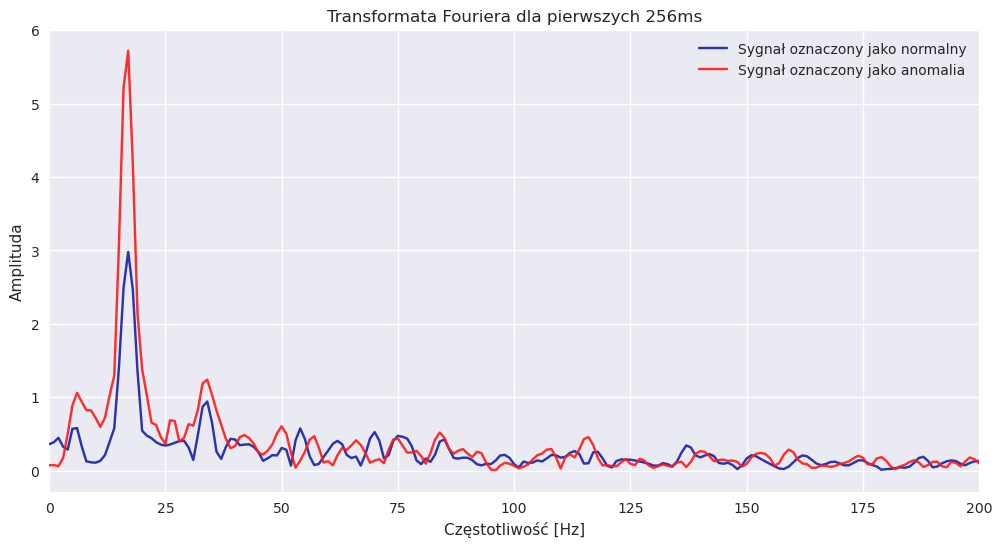

In [11]:
n_fft = 4096
hop_length = 512
blue = '#1520A6' #azure
red = '#ff1a1a'

D_normal = numpy.abs(librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))
D_abnormal = numpy.abs(librosa.stft(abnormal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))

fig = mplot.figure(figsize=(12, 6))
mplot.plot(D_normal, color=blue, alpha=0.9, label='Sygnał oznaczony jako normalny');
mplot.plot(D_abnormal, color=red, alpha=0.9, label='Sygnał oznaczony jako anomalia');
mplot.title('Transformata Fouriera dla pierwszych 256ms')
mplot.xlabel('Częstotliwość [Hz]')
mplot.ylabel('Amplituda')
mplot.legend()
mplot.xlim(0, 200);

###Spektrogramy

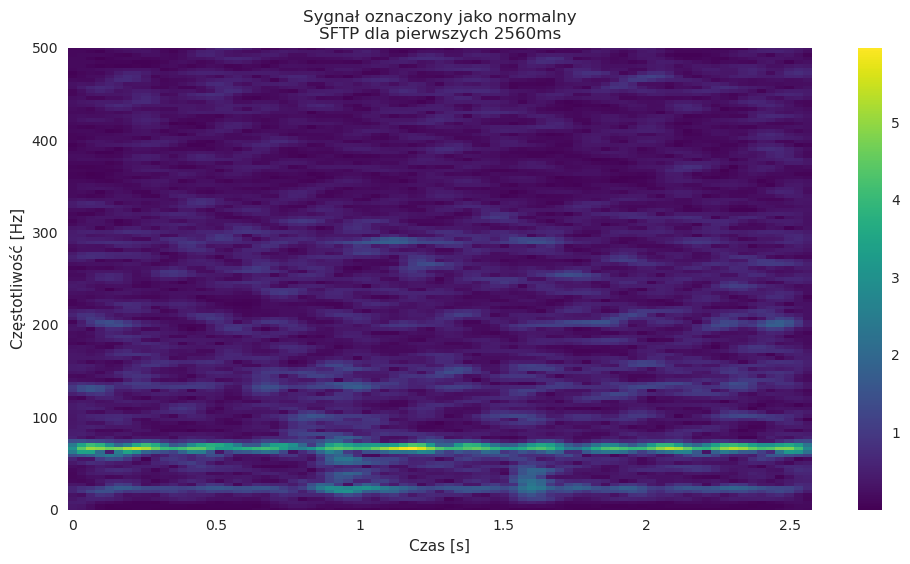

In [14]:
n_fft = 4096
D_normal = np.abs(librosa.stft(normal_signal[:10*n_fft], n_fft=n_fft, hop_length=hop_length))
dB_normal = sound_tools.get_magnitude_scale(normal_signal_file)

fig = mplot.figure(figsize=(12, 6))
librosa.display.specshow(D_normal, sr=sr, x_axis='time', y_axis='linear', cmap='viridis');
mplot.title('Sygnał oznaczony jako normalny\nSFTP dla pierwszych 2560ms')
mplot.ylim(0, 500)
mplot.xlabel('Czas [s]')
mplot.ylabel('Częstotliwość [Hz]')
mplot.colorbar()
mplot.show()

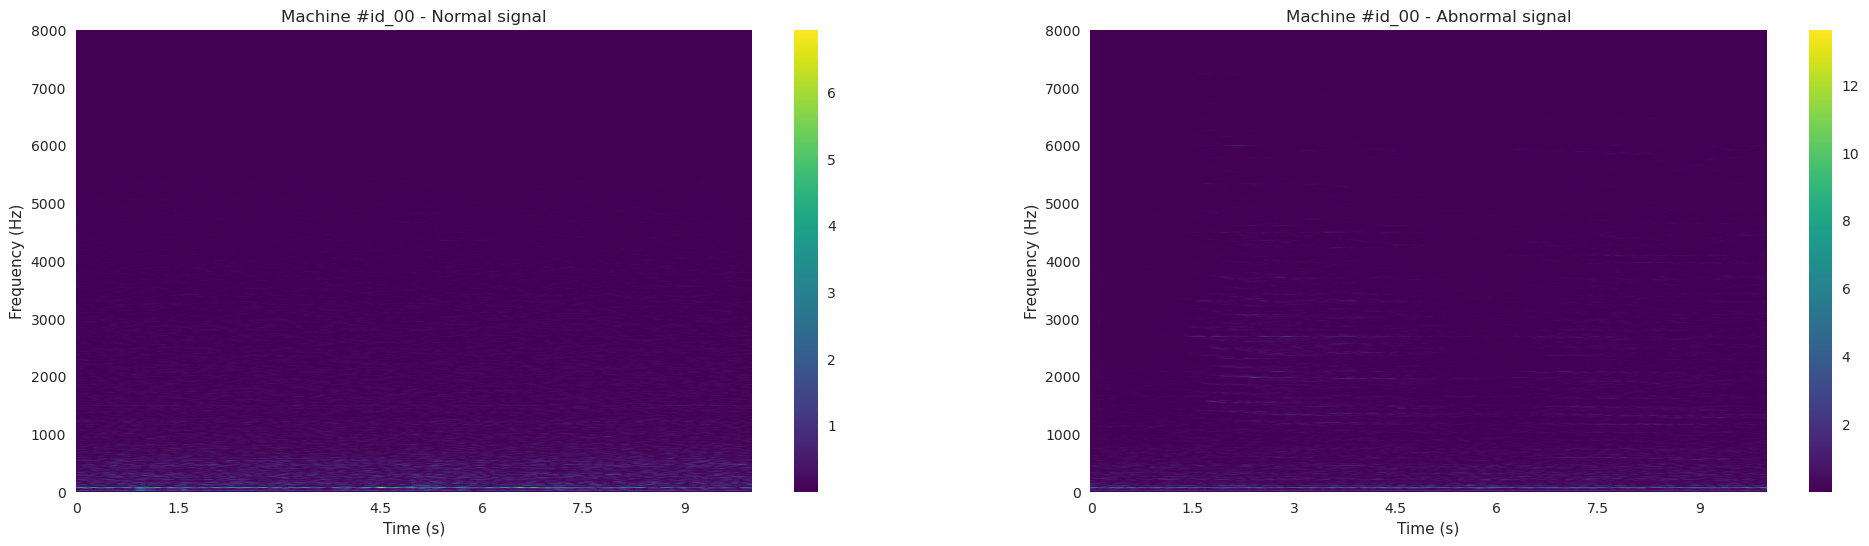

In [15]:
D_normal = numpy.abs(librosa.stft(normal_signal, n_fft=n_fft, hop_length=hop_length))
D_abnormal = numpy.abs(librosa.stft(abnormal_signal, n_fft=n_fft, hop_length=hop_length))

fig = mplot.figure(figsize=(24, 6))
mplot.subplot(1, 2, 1)
librosa.display.specshow(D_normal, sr=sr, x_axis='time', y_axis='linear', cmap='viridis');
mplot.title('Machine #id_00 - Normal signal')
mplot.xlabel('Time (s)')
mplot.ylabel('Frequency (Hz)')
mplot.colorbar();

mplot.subplot(1, 2, 2)
librosa.display.specshow(D_abnormal, sr=sr, x_axis='time', y_axis='linear', cmap='viridis');
mplot.title('Machine #id_00 - Abnormal signal')
mplot.xlabel('Time (s)')
mplot.ylabel('Frequency (Hz)')
mplot.colorbar();

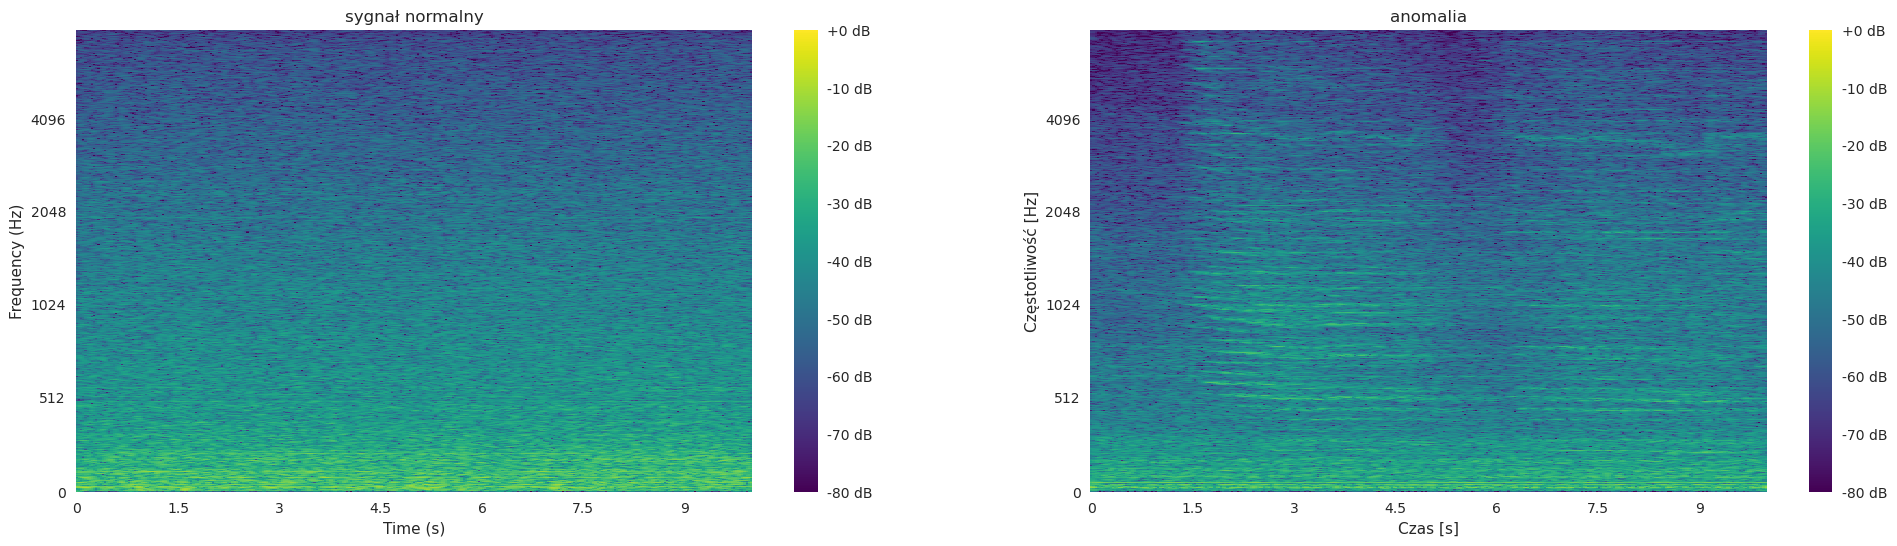

In [16]:
def load_sound_file(wav_name, mono=False, channel=0):
    multi_channel_data, sampling_rate = librosa.load(wav_name, sr=None, mono=mono)
    signal = np.array(multi_channel_data)[channel, :]
    return signal, sampling_rate

def get_magnitude_scale(file, n_fft=1024, hop_length=512):
    signal, sampling_rate = load_sound_file(file)
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    dB = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return dB

dB_normal = get_magnitude_scale(normal_signal_file, n_fft=n_fft, hop_length=hop_length)
dB_abnormal = get_magnitude_scale(abnormal_signal_file, n_fft=n_fft, hop_length=hop_length)

fig = mplot.figure(figsize=(24, 6))

mplot.subplot(1, 2, 1)
librosa.display.specshow(dB_normal, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
mplot.title('sygnał normalny')
mplot.colorbar(format="%+2.f dB")
mplot.xlabel('Time (s)')
mplot.ylabel('Frequency (Hz)')

mplot.subplot(1, 2, 2)
librosa.display.specshow(dB_abnormal, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
mplot.title('anomalia')
mplot.ylabel('Częstotliwość [Hz]')
mplot.colorbar(format="%+2.f dB")
mplot.xlabel('Czas [s]')
mplot.ylabel('Częstotliwość [Hz]')

mplot.show()

###Mel 

/tmp/ipykernel_6501/2250064320.py:1: FutureWarning: Pass y=[ 0.00271606  0.00195312  0.00250244 ... -0.00064087 -0.00042725
  0.00308228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  normal_mel = librosa.feature.melspectrogram(normal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
/tmp/ipykernel_6501/2250064320.py:3: FutureWarning: Pass y=[0.00723267 0.00756836 0.00732422 ... 0.00598145 0.00363159 0.00131226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  abnormal_mel = librosa.feature.melspectrogram(abnormal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)


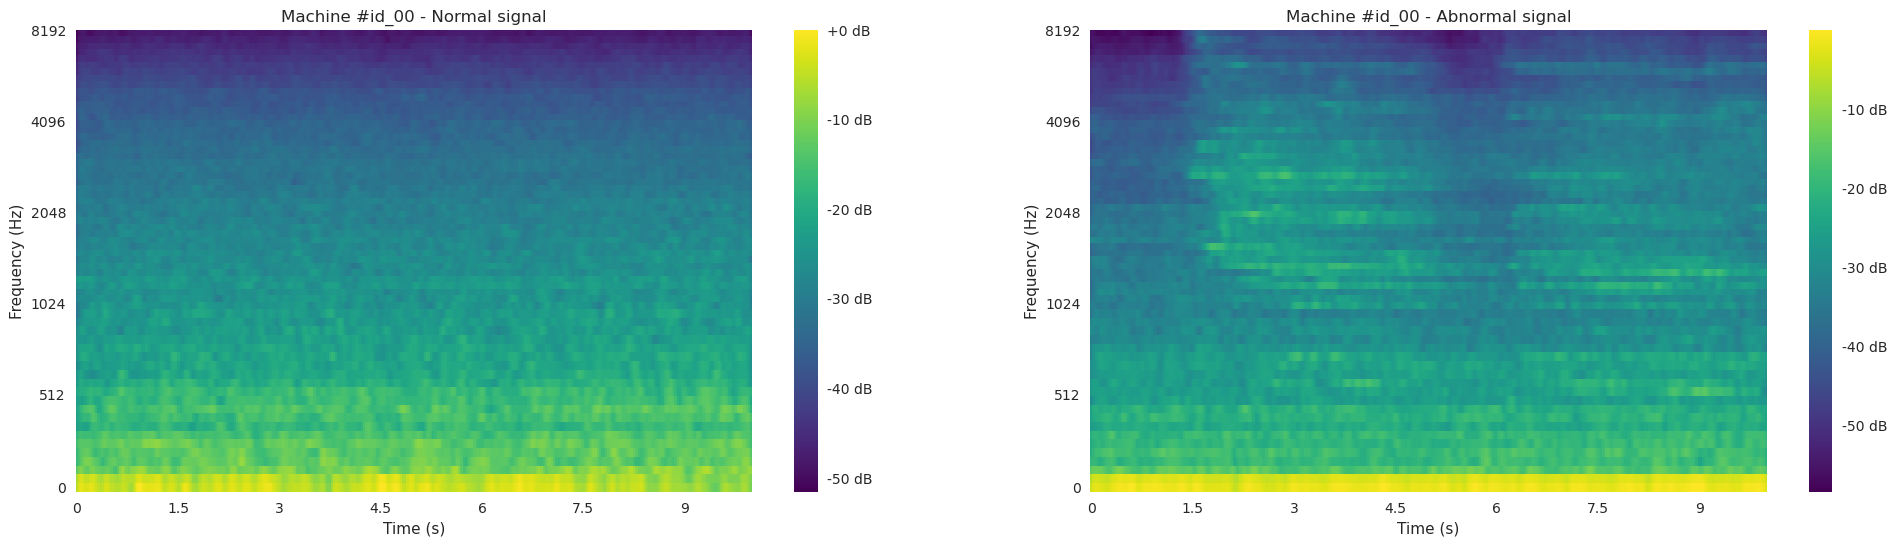

In [17]:
normal_mel = librosa.feature.melspectrogram(normal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
normal_S_DB = librosa.power_to_db(normal_mel, ref=np.max)
abnormal_mel = librosa.feature.melspectrogram(abnormal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
abnormal_S_DB = librosa.power_to_db(abnormal_mel, ref=np.max)

fig = mplot.figure(figsize=(24, 6))
mplot.subplot(1, 2, 1)
librosa.display.specshow(normal_S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis');
mplot.title('Machine #id_00 - Normal signal')
mplot.xlabel('Time (s)')
mplot.ylabel('Frequency (Hz)')
mplot.colorbar(format='%+2.0f dB');

mplot.subplot(1, 2, 2)
librosa.display.specshow(abnormal_S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis');
mplot.title('Machine #id_00 - Abnormal signal')
mplot.xlabel('Time (s)')
mplot.ylabel('Frequency (Hz)')
mplot.colorbar(format='%+2.0f dB');